In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import mygene
from scipy import stats
import numpy as np
mg = mygene.MyGeneInfo()

SAMPLE_ANNOTATION = "../data/annotation/GTEx_Data_V6_Annotations_SampleAttributesDS.txt"
EXON_EXPR_DATA = "../data/GTEx_Analysis_v6_RNA-seq_RNA-SeQCv1.1.8_exon_reads.txt"
EXON_REF = "../data/gencode.v19.genes.patched_contigs_exons.txt"
PHENOTYPE_ANNOTATION = "../data/annotation/GTEx_Data_V6_Annotations_SubjectPhenotypesDS.txt"


GENE_SYMBOL = "TNMD"
TISSUES = ["Muscle - Skeletal", "Cells - Transformed fibroblasts"]
MIN_THRESHOLD = 20

In [26]:
exon = pd.read_table(EXON_EXPR_DATA, nrows=50)


# Convert ensemble gene id to gene symbol
exon["ensemblGeneId"] = exon.apply(lambda row: row["Id"].split(".")[0], axis=1)

missing_symbol_count = 0
def convertToSymbol(row):
    d = mg.getgene(row["ensemblGeneId"])
    if(d == None):
        global missing_symbol_count
        missing_symbol_count += 1
        return None
    return d["symbol"]

exon["symbol"] = exon.apply(convertToSymbol, axis=1)
print("missing {} of gene_id -> symbol conversion".format(missing_symbol_count))




missing 0 of gene_id -> symbol conversion


['ENSG00000000003',
 'ENSG00000000005',
 'ENSG00000000419',
 'ENSG00000000457',
 'ENSG00000000460']

In [7]:
# Join exon reference table with exon expression table
exon_ref = pd.read_table(EXON_REF)

exon_ref["Id"] = exon_ref["Gene"]
del exon_ref["Gene"]

exon = exon.set_index('Id').join(exon_ref.set_index('Id')).reset_index()

# Create a exon_count column  
exon["exon_count"] = exon.groupby("ensemblGeneId")["ensemblGeneId"].transform('count')
exon


/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Id  GTEX-1117F-0426-SM-5EGHI  GTEX-1117F-0626-SM-5N9CS  \
0    ENSG00000000003.10_0                    156.21                   1344.38   
1    ENSG00000000003.10_1                     26.85                    181.70   
2    ENSG00000000003.10_2                     18.54                    123.89   
3    ENSG00000000003.10_3                     35.20                    228.74   
4    ENSG00000000003.10_4                     22.08                    162.87   
5    ENSG00000000003.10_5                     21.46                    112.96   
6    ENSG00000000003.10_6                     33.41                    230.78   
7    ENSG00000000003.10_7                     44.25                    220.68   
8    ENSG00000000003.10_8                      0.00                      0.00   
9     ENSG00000000005.5_0                      0.00                      1.16   
10    ENSG00000000005.5_1                      0.00                      1.96   
11    ENSG00000000005.5_2                      3.17                     35.25   
12    ENSG00000000005.5_3                      1.82                     30.68   
13    ENSG00000000005.5_4                      3.01                     43.96   
14    ENSG00000000005.5_5                      7.39                     40.75   
15    ENSG00000000005.5_6                      8.60                     75.24   
16    ENSG00000000419.8_0                    698.74                    371.33   
17    ENSG00000000419.8_1                    326.30                    156.38   
18    ENSG00000000419.8_2                    147.58                    124.37   
19    ENSG00000000419.8_3                      9.58                      2.70   
20    ENSG00000000419.8_4                    218.46                    135.95   
21    ENSG00000000419.8_5                     58.74                     29.90   
22    ENSG00000000419.8_6                    196.30                    129.51   
23    ENSG00000000419.8_7                     89.17                     62.65   
24    ENSG00000000419.8_8                    223.30                    125.20   
25    ENSG00000000419.8_9                    235.67                    142.03   
26    ENSG00000000457.9_0                     78.36                    267.41   
27    ENSG00000000457.9_1                     13.96                      9.09   
28   ENSG00000000457.9_10                      2.67                     40.20   
29   ENSG00000000457.9_11                      6.68                     23.15   
30   ENSG00000000457.9_12                      1.07                     20.03   
31   ENSG00000000457.9_13                      0.00                      1.00   
32    ENSG00000000457.9_2                     10.82                     45.01   
33    ENSG00000000457.9_3                     21.04                     47.60   
34    ENSG00000000457.9_4                      8.00                     21.03   
35    ENSG00000000457.9_5                      3.82                     16.46   
36    ENSG00000000457.9_6                     10.01                     24.76   
37    ENSG00000000457.9_7                      3.55                     16.92   
38    ENSG00000000457.9_8                      1.17                      6.61   
39    ENSG00000000457.9_9                      3.86                     28.74   
40   ENSG00000000460.12_0                      2.00                      0.00   
41   ENSG00000000460.12_1                      1.00                      2.00   
42  ENSG00000000460.12_10                      4.95                      6.78   
43  ENSG00000000460.12_11                      2.87                      5.33   
44  ENSG00000000460.12_12                      0.00                      3.88   
45  ENSG00000000460.12_13                      0.00                      9.93   
46  ENSG00000000460.12_14                      2.64                      5.37   
47  ENSG00000000460.12_15                      3.42                      6.54   
48  ENSG00000000460.12_16                      0.16   

In [11]:
# Get proper exon number based on strand +/-
# Given id = ENSG00000000003.10_0, exon_num = 0
# if strand -> + : exon += 1
# if strand -> - : exon = exon_count - exon_num
def getProperExonNumber(row):
    if(row.strand == "+"):
#         print("pos strand {} {}".format(row.Id, row.strand))
        return int(row.Id.split("_")[1]) + 1;
    elif(row.strand == "-"):
#         print("neg strand {} {}".format(row.Id, row.strand))
        return row.exon_count - int(row.Id.split("_")[1])
    else:
        raise Exception("invalid strand value (not +/-)")
        
exon["exon"] = exon.apply(getProperExonNumber, axis=1)
exon

Id  GTEX-1117F-0426-SM-5EGHI  GTEX-1117F-0626-SM-5N9CS  \
0    ENSG00000000003.10_0                    156.21                   1344.38   
1    ENSG00000000003.10_1                     26.85                    181.70   
2    ENSG00000000003.10_2                     18.54                    123.89   
3    ENSG00000000003.10_3                     35.20                    228.74   
4    ENSG00000000003.10_4                     22.08                    162.87   
5    ENSG00000000003.10_5                     21.46                    112.96   
6    ENSG00000000003.10_6                     33.41                    230.78   
7    ENSG00000000003.10_7                     44.25                    220.68   
8    ENSG00000000003.10_8                      0.00                      0.00   
9     ENSG00000000005.5_0                      0.00                      1.16   
10    ENSG00000000005.5_1                      0.00                      1.96   
11    ENSG00000000005.5_2                      3.17                     35.25   
12    ENSG00000000005.5_3                      1.82                     30.68   
13    ENSG00000000005.5_4                      3.01                     43.96   
14    ENSG00000000005.5_5                      7.39                     40.75   
15    ENSG00000000005.5_6                      8.60                     75.24   
16    ENSG00000000419.8_0                    698.74                    371.33   
17    ENSG00000000419.8_1                    326.30                    156.38   
18    ENSG00000000419.8_2                    147.58                    124.37   
19    ENSG00000000419.8_3                      9.58                      2.70   
20    ENSG00000000419.8_4                    218.46                    135.95   
21    ENSG00000000419.8_5                     58.74                     29.90   
22    ENSG00000000419.8_6                    196.30                    129.51   
23    ENSG00000000419.8_7                     89.17                     62.65   
24    ENSG00000000419.8_8                    223.30                    125.20   
25    ENSG00000000419.8_9                    235.67                    142.03   
26    ENSG00000000457.9_0                     78.36                    267.41   
27    ENSG00000000457.9_1                     13.96                      9.09   
28   ENSG00000000457.9_10                      2.67                     40.20   
29   ENSG00000000457.9_11                      6.68                     23.15   
30   ENSG00000000457.9_12                      1.07                     20.03   
31   ENSG00000000457.9_13                      0.00                      1.00   
32    ENSG00000000457.9_2                     10.82                     45.01   
33    ENSG00000000457.9_3                     21.04                     47.60   
34    ENSG00000000457.9_4                      8.00                     21.03   
35    ENSG00000000457.9_5                      3.82                     16.46   
36    ENSG00000000457.9_6                     10.01                     24.76   
37    ENSG00000000457.9_7                      3.55                     16.92   
38    ENSG00000000457.9_8                      1.17                      6.61   
39    ENSG00000000457.9_9                      3.86                     28.74   
40   ENSG00000000460.12_0                      2.00                      0.00   
41   ENSG00000000460.12_1                      1.00                      2.00   
42  ENSG00000000460.12_10                      4.95                      6.78   
43  ENSG00000000460.12_11                      2.87                      5.33   
44  ENSG00000000460.12_12                      0.00                      3.88   
45  ENSG00000000460.12_13                      0.00                      9.93   
46  ENSG00000000460.12_14                      2.64                      5.37   
47  ENSG00000000460.12_15                      3.42                      6.54   
48  ENSG00000000460.12_16                      0.16   

In [21]:
# Extract exon read counts with given arbitrary GENE_SYMBOL

# subset based on symbol 
df = exon.loc[
    (exon["symbol"] == GENE_SYMBOL)
]


df_t = df.transpose() 

# save gene specific metadata to dataframe._metadata
genedata = {}
genedata["gene_symbol"] = GENE_SYMBOL
genedata["ensembl_id"] = df["ensemblGeneId"].iloc[0]
genedata["chr"] = df["CHR"].iloc[0]
print(genedata)


# Drop irrelevant rows
df_t.columns = df_t.loc["exon"]
df_t = df_t.drop(["ensemblGeneId", 
           "symbol", 
           "CHR", 
           "start", 
           "stop", 
           "strand", 
           "exon_count", 
           "exon", 
           "Id"])
df_t

{'gene_symbol': 'TNMD', 'ensembl_id': 'ENSG00000000005', 'chr': 'X'}


exon                          1      2       3       4       5       6       7
GTEX-1117F-0426-SM-5EGHI      0      0    3.17    1.82    3.01    7.39     8.6
GTEX-1117F-0626-SM-5N9CS   1.16   1.96   35.25   30.68   43.96   40.75   75.24
GTEX-1117F-0726-SM-5GIEN      0      0       0    0.54    1.46       0       0
GTEX-1117F-1326-SM-5EGHH   1.95   1.05  128.43   62.71   96.18  129.91  172.76
GTEX-1117F-2426-SM-5EGGH      0      0       4    0.29    4.71       2       2
GTEX-1117F-2526-SM-5GZY6      0      0     2.7    3.82    3.57    4.92       9
GTEX-1117F-2826-SM-5GZXL  10.28  23.45  300.91  178.68  328.57  347.92  497.72
GTEX-1117F-2926-SM-5GZYI      0   0.33   12.28    8.85   11.16    6.78    13.6
GTEX-1117F-3026-SM-5GZYU   0.18   3.76    5.01    5.03    6.24    7.91   12.87
GTEX-1117F-3226-SM-5N9CT      0      0       0       0       0    0.93    1.07
GTEX-111CU-0126-SM-5GZWZ      0      0    0.79    0.75    0.46    0.26    1.74
GTEX-111CU-0226-SM-5GZXC      0      0    0.88    3.26    0.86       0       1
GTEX-111CU-0326-SM-5GZXO      0      0       3       0    2.42    2.58       2
GTEX-111CU-0526-SM-5EGHK      0      0       0       0       0       0       0
GTEX-111CU-0626-SM-5EGHL      0      0    3.83    1.17       1       0       0
GTEX-111CU-0726-SM-5GZYD      0      0       0       0       1       1       0
GTEX-111CU-0826-SM-5EGIJ      0      0       4       0       0       0       4
GTEX-111CU-0926-SM-5EGIK      0      0       0       0    0.22    1.78       0
GTEX-111CU-1026-SM-5EGIL      1   2.67   46.12    31.8    42.3   63.41    92.7
GTEX-111CU-1126-SM-5EGIM      0      0    2.58    0.74     1.3    3.12    8.26
GTEX-111CU-1226-SM-5EGIN      0      0       4    3.46    5.37    4.17       4
GTEX-111CU-1326-SM-5NQ8L      0      0       3    1.45    3.01    4.93    3.61
GTEX-111CU-1426-SM-5GZYP      0      0    3.43    5.97    2.59    0.53    7.47
GTEX-111CU-1526-SM-5N9FS      0      0       0       0       0    1.38    4.62
GTEX-111CU-1726-SM-5EGHM      0      0       0       0       2    0.63    5.37
GTEX-111CU-1826-SM-5GZYN      0      0   23.95   31.63   38.78    41.4   71.25
GTEX-111CU-1926-SM-5GZYZ   0.57   4.16   15.26    12.6   24.18   41.97   64.25
GTEX-111CU-2026-SM-5GZZC      0      0       0       0    0.29    1.71       0
GTEX-111CU-2226-SM-5N9G5   13.8  24.74   43.22    27.3    46.2   36.72   55.01
GTEX-111FC-0126-SM-5N9DL  17.17  24.74   32.88   20.72   35.74   27.04   62.71
...                         ...    ...     ...     ...     ...     ...     ...
GTEX-ZZ64-1326-SM-5E444       0      0    2.46    0.54    2.63    2.89    3.47
GTEX-ZZ64-1426-SM-5NQ8C   47.05  67.33  121.04   77.26   131.5   151.5  231.32
GTEX-ZZ64-1526-SM-5E43K       0      0    3.16    1.39    2.11    4.41    2.93
GTEX-ZZ64-1626-SM-5E43W    4.49  13.07  207.91  116.42  214.99  252.17  336.96
GTEX-ZZ64-1726-SM-5GZYB       0      0       3    1.12    9.51    8.83   14.54
GTEX-ZZPT-0226-SM-5E43X    1.04   2.78    1.55    2.45    2.18    2.29    4.71
GTEX-ZZPT-0626-SM-5GZXT       0      0       0    1.21    0.79       0       1
GTEX-ZZPT-0926-SM-5GICZ       0      0       0       2    2.99    3.01       2
GTEX-ZZPT-1326-SM-5E43H       0      0    5.96    1.92    2.62    2.33    1.17
GTEX-ZZPT-1426-SM-5N9C5       0      0       0       0       0       0       0
GTEX-ZZPT-2926-SM-5EQ5S       0      1       1       0       0       0       0
GTEX-ZZPT-3026-SM-5GZXH       0      0       0       0    4.05    2.37    3.58
GTEX-ZZPU-0126-SM-5E446       0      0       0       0       0       0       0
GTEX-ZZPU-0326-SM-5N9BJ       0      0   29.04    21.1   38.45   48.47   66.93
GTEX-ZZPU-0426-SM-5GZYH       0      0       0       0       0       0       0
GTEX-ZZPU-0526-SM-5E44U       0      0    1.71    1.82    0.47       0       4
GTEX-ZZPU-0626-SM-5E43T    0.92   1.08   18.57   14.21   22.97   37.99   33.26
GTEX-ZZPU-0726-SM-5N9C8       0      0       0       0       0       0       2
GTEX-ZZPU-0826-SM-5GZX5       1      1    5.16    

In [22]:
# Group gene-specific exon expression by tissue type 
# End result a 53 (SMTSD) x ~10 (exon_counts), each cell holds an array 


# merge with sample annotation (specifically SMTSD, tissue type detail)
smp_anno = pd.read_table(SAMPLE_ANNOTATION)
smp_anno_extr = smp_anno[["SAMPID", "SMTSD"]]
df_tissue = df_t.join(smp_anno_extr.set_index('SAMPID')).set_index("SMTSD")

# populate list by tissue type
# all_tissue_expr = { exon_num: {tissueType: [ expr...], ...} }
all_tissue_expr = {}
for col in df_tissue.columns:
    cur_tissue_expr = df_tissue.groupby(df_tissue.index)[col].apply(lambda x: list(x)).to_dict()
    all_tissue_expr[col] = cur_tissue_expr

genedata["exon_expression"] = all_tissue_expr
genedata

{'chr': 'X',
 'ensembl_id': 'ENSG00000000005',
 'exon_expression': {1: {'Adipose - Subcutaneous': [0.0,
    53.25,
    12.07,
    6.04,
    2.36,
    1.0,
    3.38,
    0.0,
    10.46,
    3.22,
    4.25,
    35.07,
    0.47,
    2.28,
    8.21,
    2.82,
    20.9,
    13.28,
    8.92,
    7.04,
    34.96,
    14.75,
    12.09,
    635.5,
    2.95,
    9.57,
    9.34,
    43.12,
    6.87,
    8.85,
    28.18,
    41.68,
    7.76,
    10.58,
    8.32,
    1.57,
    11.22,
    18.28,
    20.34,
    1.92,
    10.12,
    47.58,
    3.01,
    11.09,
    16.15,
    9.68,
    50.75,
    1.38,
    1.0,
    39.59,
    32.26,
    18.55,
    8.62,
    41.63,
    39.05,
    4.09,
    57.3,
    0.92,
    27.05,
    28.99,
    31.43,
    1.0,
    36.16,
    26.9,
    3.67,
    4.43,
    2.59,
    29.12,
    3.3,
    0.0,
    12.1,
    1.57,
    13.28,
    16.35,
    10.41,
    36.59,
    3.0,
    3.84,
    43.4,
    4.42,
    101.57,
    21.26,
    21.59,
    20.42,
    28.01,
    8.54,
    3.72,
  

In [23]:
# Pre-process data for bar plots


def subsetBasedOnTissue(data, tissues):
    """ extract expression data for one gene
    given a list of tissues in interest 
        
        @param data: pre-computed data (per gene)
        @param tissues: [tissueType: str]
        @rType:            
            [{tissueType: {indexas(exon_num): [expr...]}}...]
    """
    expr = genedata["exon_expression"]
    
    ret = []
    
    for tissue in tissues:
        cur_tissue_expr = {}
        for exon_num in expr:
            cur_tissue_expr[exon_num] = expr[exon_num][tissue]
        ret.append({tissue: cur_tissue_expr}) 
    return ret


subs = subsetBasedOnTissue(genedata, TISSUES)



# plotd: [ each tissue:{means:[], exons: []}, ... ]
plotd = []

for t in subs:
    tissue_expression = t.values()
    exons = []
    means = []
    stdevs = []
    for exons_expr in tissue_expression:
        # k: {indexas(exon_num): [expr...]}
        for exon_num in exons_expr.keys():
            exons.append(exon_num)
            means.append(np.mean(exons_expr[exon_num]))
            stdevs.append(np.std(exons_expr[exon_num]))
    plotd.append({
            "mean": means,
            "exon": exons,
            "stdev": stdevs
        })
print(plotd)
 

[{'mean': [5.1819302325581393, 7.1707674418604643, 14.143837209302326, 9.8450232558139525, 14.840069767441861, 18.15746511627907, 25.688395348837211], 'exon': [1, 2, 3, 4, 5, 6, 7], 'stdev': [17.714270078491442, 27.004635969211609, 46.191472488162383, 33.007530069342195, 50.923933366640256, 60.514065651829235, 87.438604860686297]}, {'mean': [0.091795774647887324, 0.13757042253521126, 0.3670070422535211, 0.24873239436619718, 0.43109154929577465, 0.58341549295774642, 0.65095070422535217], 'exon': [1, 2, 3, 4, 5, 6, 7], 'stdev': [0.4213199586867209, 0.5308424860923121, 1.0636777747048733, 0.7692303260951221, 1.1750911885797977, 1.6976514296702303, 1.6466864330641497]}]


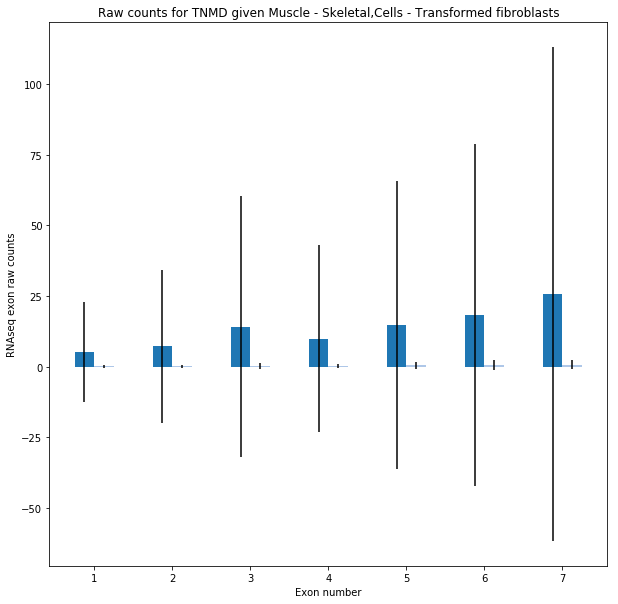

In [24]:
# Plotting barplot y-axis: raw counts, x-axis: exon number for GENE_SYMBOL given TISSUES

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
            (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
            (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
            (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
            (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.) 

num_of_exons = len(plotd[0]["mean"])

fig, ax = plt.subplots()
fig.set_size_inches((10,10))

width = 0.25

ticks = []
ind = np.empty(num_of_exons)

for i, tissue in enumerate(plotd):
    ind = np.arange(len(tissue["mean"]))
    
    ax.bar(ind + width*i, tissue["mean"], width, color=tableau20[i%20],yerr=tissue["stdev"])
    ticks = tissue["exon"]
    
ax.set_title("Raw counts for {} given {}".format(GENE_SYMBOL, ",".join(TISSUES)))
ax.set_ylabel("RNAseq exon raw counts")
ax.set_xlabel("Exon number")

plt.xticks(ind + width / 2, ticks)

plt.show()
